In [42]:
! pip install transformers datasets
! pip install datasets
! pip install evaluate
! pip install jiwer
! pip install diffusers
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np
! pip install -U accelerate
! pip install -U transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.9 MB/s eta 0:00:00


## Load the data

We take the pixel art dataset instead of the DiffusionDB due to its relatively small size

In [2]:
from datasets import load_dataset

dataset = load_dataset("jainr3/diffusiondb-pixelart")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1000
    })
})

Let's look at an example. First the image:

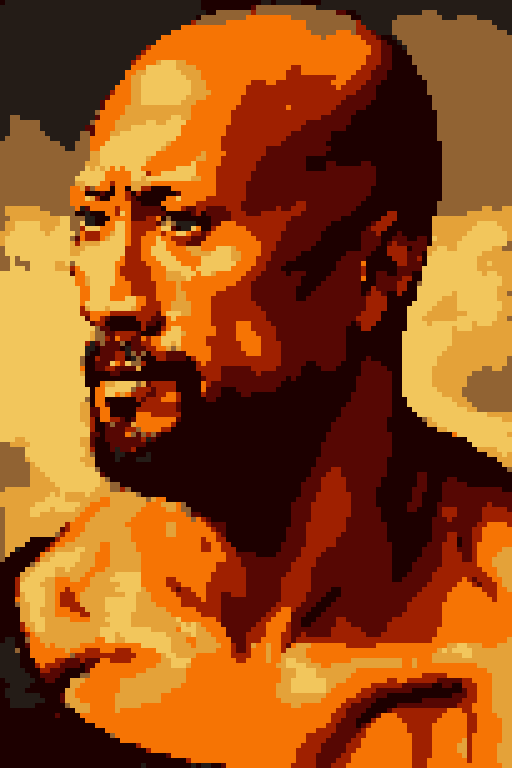

In [4]:
dataset["train"]['image'][0]

Then the corresponding prompt:

In [5]:
dataset["train"]['text'][0]

'a renaissance portrait of dwayne johnson, art in the style of rembrandt!! intricate. ultra detailed, oil on canvas, wet - on - wet technique, pay attention to facial details, highly realistic, cinematic lightning, intricate textures, illusionistic detail, '

We split the dataset to have a test set

In [6]:
dataset = dataset["train"].train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

Let's look at a sample of images with their prompts attached

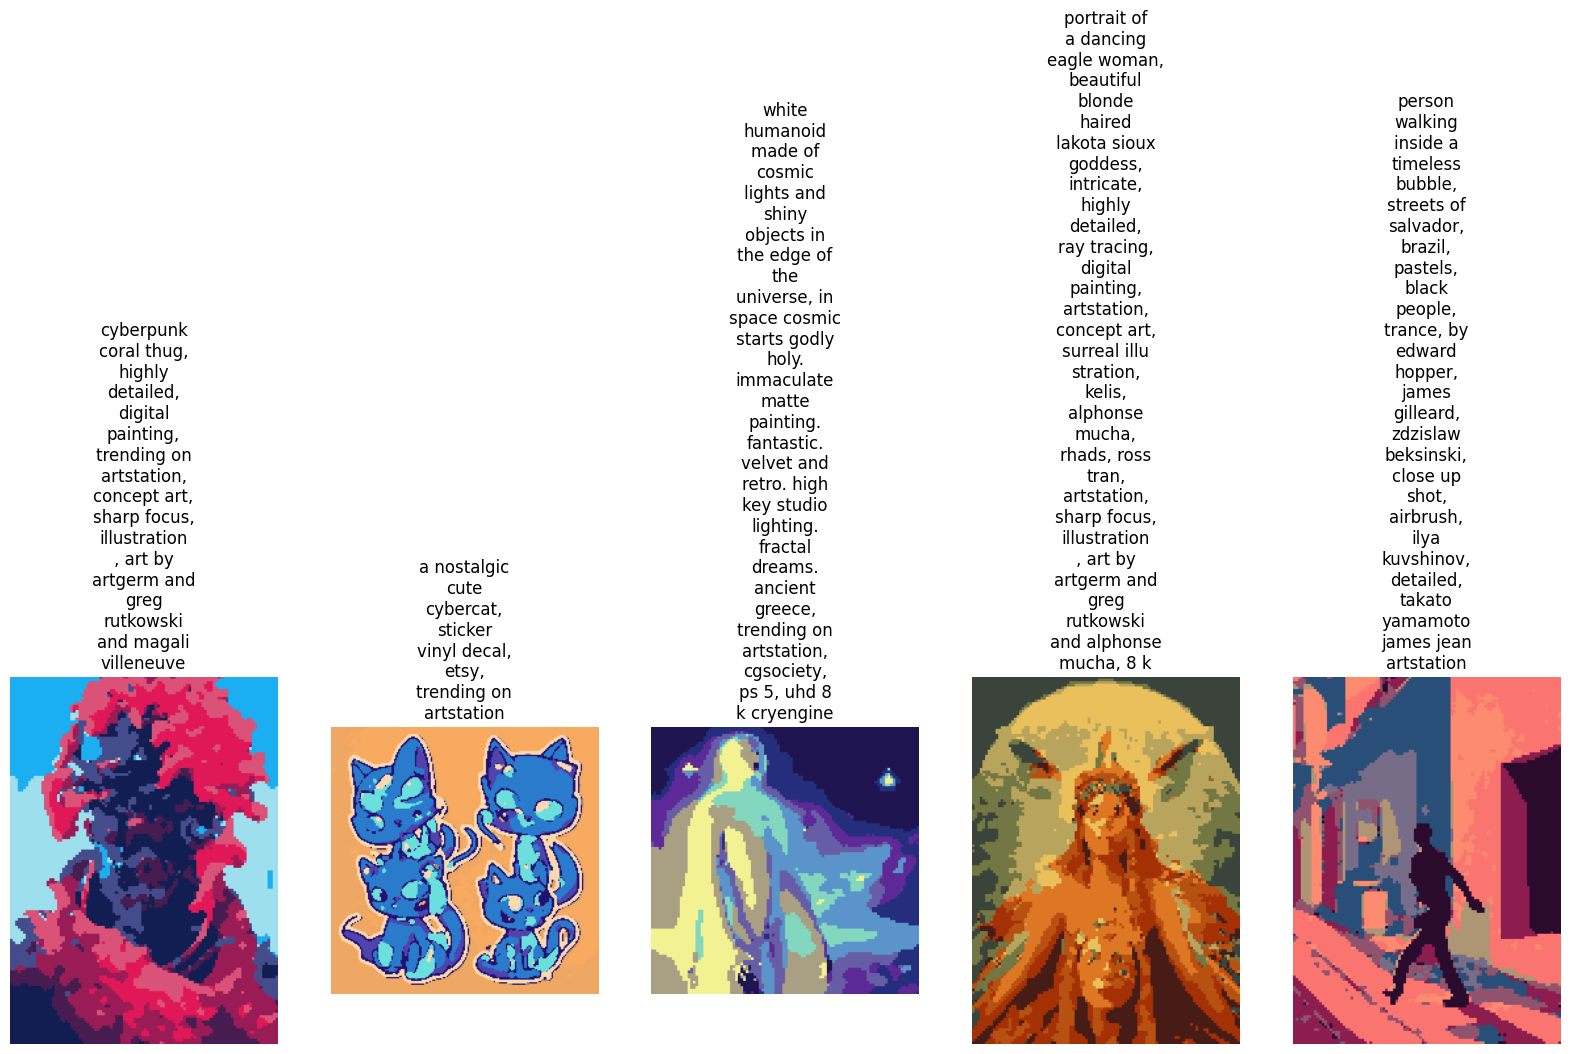

In [7]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Process the dataset

Multimodel model to process both images and captions

In [8]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

In [9]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

Load the model

In [10]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

Word Error Rate metric

In [11]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

## Train the model

I choose training arguments such as they don't overload the CUDA memory (batch sizes = 1)

In [12]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"reverse_sd_pixel",
    learning_rate=5e-5,
    num_train_epochs=8,
    fp16=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
    hub_token='',
)

I got "out of memory" CUDA messages so I decreased as much as possible the train and eval batch sizes and I decreased the size of the training set.

In [13]:
train_ds2 = train_ds.select(range(300))
train_ds2

Dataset({
    features: ['image', 'text'],
    num_rows: 300
})

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds2,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [15]:
trainer.train()

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Step,Training Loss,Validation Loss,Wer Score
50,7.550400,4.689943,5.822928
100,2.534400,0.716027,4.941950
150,0.465600,0.424173,0.960570
200,0.394500,0.378831,0.958014
250,0.321000,0.346260,2.874042
300,0.318900,0.306273,6.262505
350,0.206200,0.288976,2.866375
400,0.216800,0.274945,1.374224
450,0.208900,0.270108,7.753560
500,0.164200,0.264023,3.310697


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Un

TrainOutput(global_step=2400, training_loss=0.3083019470671813, metrics={'train_runtime': 3171.339, 'train_samples_per_second': 0.757, 'train_steps_per_second': 0.757, 'total_flos': 1122438330777600.0, 'train_loss': 0.3083019470671813, 'epoch': 8.0})

Let's plot the training and test loss:

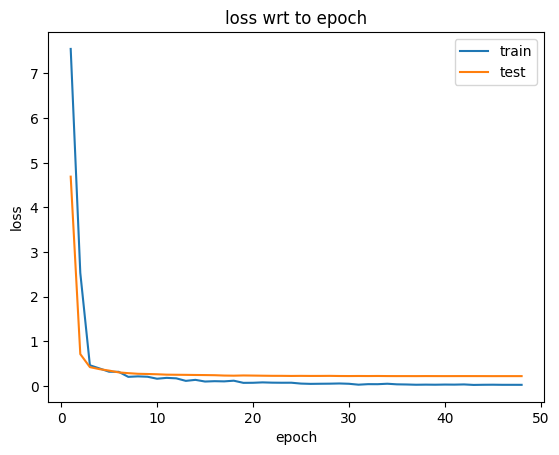

In [18]:
training_loss = []
for i in range(0, len(trainer.state.log_history)-1, 2):
  training_loss.append(trainer.state.log_history[i]['loss'])

test_loss = []
for i in range(1, len(trainer.state.log_history), 2):
  test_loss.append(trainer.state.log_history[i]['eval_loss'])

loss = [training_loss,test_loss]
x = np.arange(1,49,1)

plt.plot(x,loss[0],x,loss[1])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['train','test'])
plt.title('loss wrt to epoch')
plt.show()

Look like it reached a plateau early (no sign of overfitting though)

## Inference

Manually import an image:

Saving anime blue eye.png to anime blue eye.png


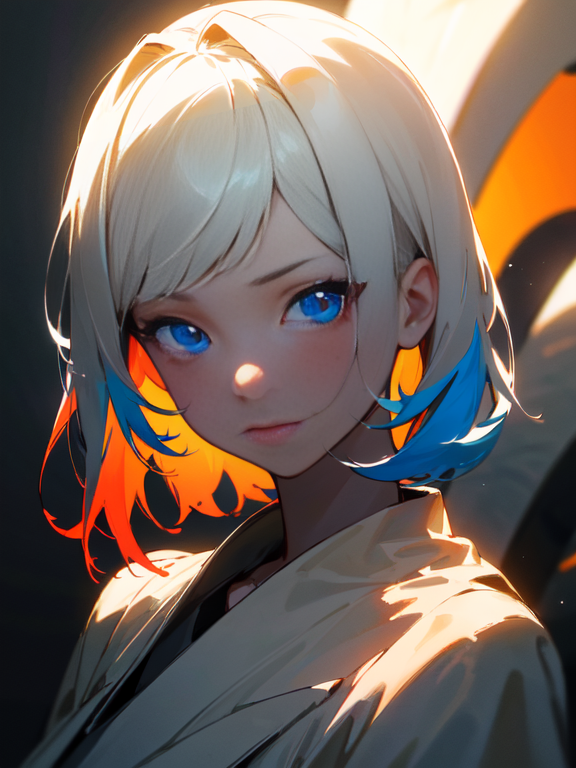

In [39]:
from google.colab import files
from PIL import Image
from io import BytesIO

uploaded = files.upload()
im = Image.open(BytesIO(uploaded['anime blue eye.png']))
im

Pass it to the trained model to get the associated predict prompt

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=im, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a portrait of girl alchemist in blue dress, magic potions, fantasy, dungeons and dragons, an ultrafine detailed painting, chibi, detailed painting, boris valejo. octopath traveler decal!!!


Looks good! Sounds like a plausible prompt

Comparison with a SD generation. This image (taken from the net) was apparently generated with the Counterfeit checkpoint

In [43]:
from diffusers import DiffusionPipeline

diffusion_pipeline = DiffusionPipeline.from_pretrained("gsdf/Counterfeit-V2.5")

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/901 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

We ensure the pipeline is attached to a GPU

In [44]:
diffusion_pipeline = diffusion_pipeline.to("cuda")

Use of the Generator in case we want to re-use the generated image

In [45]:
generator = torch.Generator("cuda").manual_seed(0)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


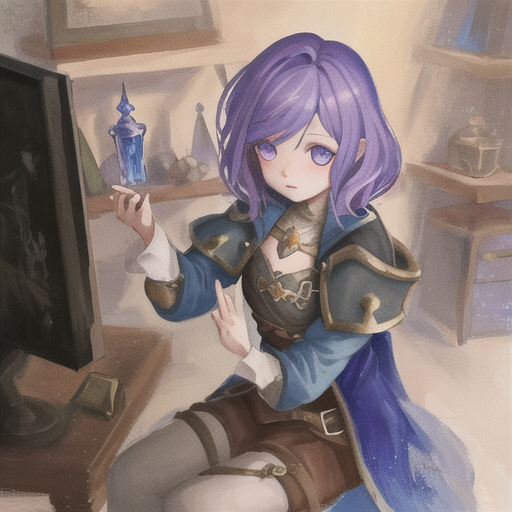

In [47]:
generated_image = diffusion_pipeline(generated_caption, generator=generator).images[0]
generated_image

Not super close